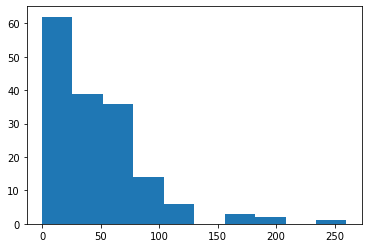

Benin
Statistics=78.493, p=0.000
Sample does not look Gaussian (reject H0)


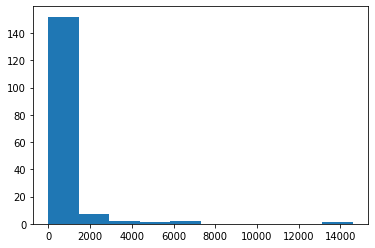

Burkina Faso
Statistics=249.258, p=0.000
Sample does not look Gaussian (reject H0)


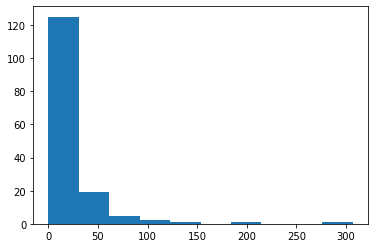

Ivory Coast
Statistics=194.676, p=0.000
Sample does not look Gaussian (reject H0)


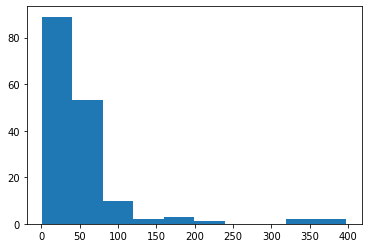

Mali
Statistics=157.826, p=0.000
Sample does not look Gaussian (reject H0)


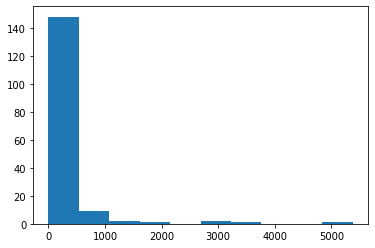

Niger
Statistics=211.954, p=0.000
Sample does not look Gaussian (reject H0)


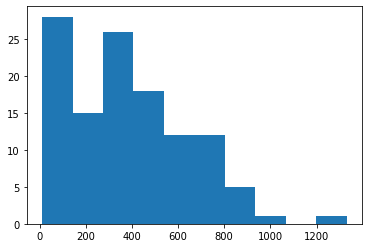

Dem. Rep. Congo
Statistics=10.836, p=0.004
Sample does not look Gaussian (reject H0)


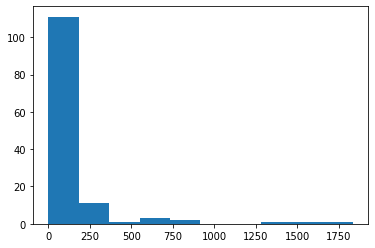

Chad
Statistics=147.478, p=0.000
Sample does not look Gaussian (reject H0)


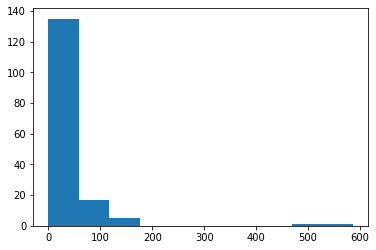

Togo
Statistics=236.564, p=0.000
Sample does not look Gaussian (reject H0)


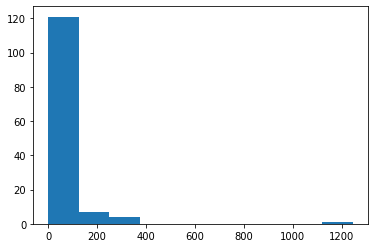

Ghana
Statistics=235.132, p=0.000
Sample does not look Gaussian (reject H0)


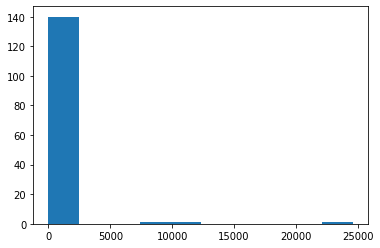

Nigeria
Statistics=264.377, p=0.000
Sample does not look Gaussian (reject H0)


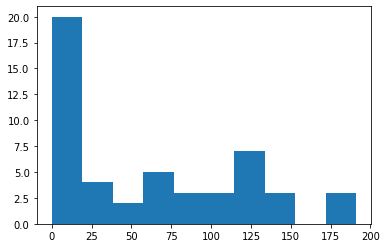

Ethiopia
Statistics=7.569, p=0.023
Sample does not look Gaussian (reject H0)


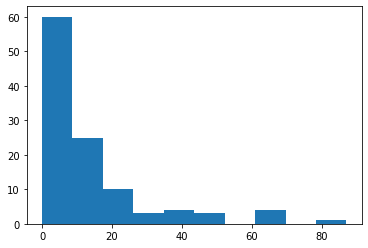

Centrafrique
Statistics=58.576, p=0.000
Sample does not look Gaussian (reject H0)


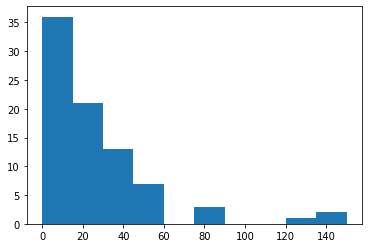

Guinea
Statistics=58.274, p=0.000
Sample does not look Gaussian (reject H0)


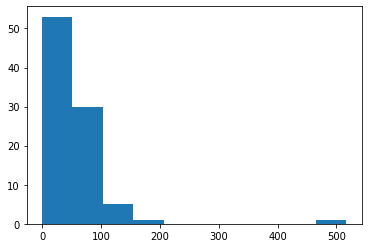

Cameroun
Statistics=134.566, p=0.000
Sample does not look Gaussian (reject H0)


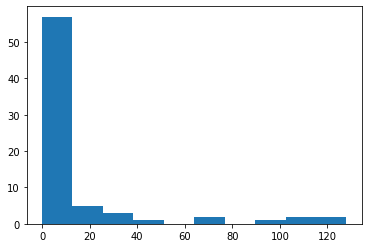

Sudan
Statistics=56.511, p=0.000
Sample does not look Gaussian (reject H0)


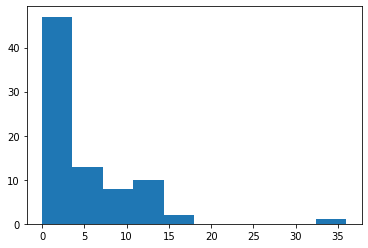

Gambia
Statistics=61.721, p=0.000
Sample does not look Gaussian (reject H0)


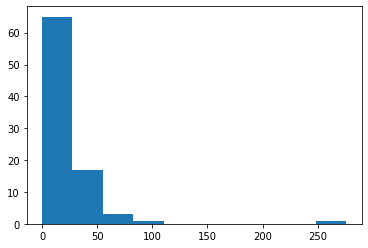

Senegal
Statistics=142.753, p=0.000
Sample does not look Gaussian (reject H0)


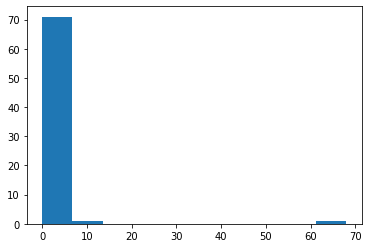

Mauritania
Statistics=157.506, p=0.000
Sample does not look Gaussian (reject H0)


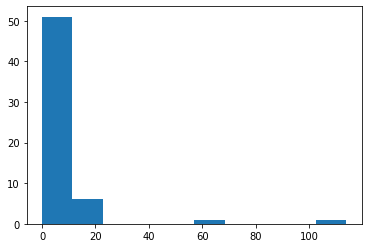

South Sudan
Statistics=101.731, p=0.000
Sample does not look Gaussian (reject H0)


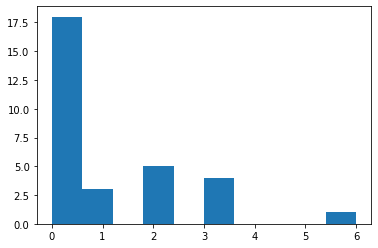

Tanzania
Statistics=17.269, p=0.000
Sample does not look Gaussian (reject H0)
19
10
13
18
20
21
9
{0: [13, 7, 13, 14, 13, 10, 5, 4, 3, 2, 2, 0, 4, 12, 13, 14, 5, 3, 10, 9, 14, 10, 1, 2, 4, 7, 26, 4, 12, 12, 23, 22, 27, 10, 12, 17, 44, 3, 4, 19, 7, 16, 9, 42, 57, 14, 14, 18, 17, 16, 18, 23, 4, 19, 5, 2, 18, 8, 6, 6, 3, 5, 4, 4, 4, 4, 9, 21, 19, 5, 19, 16, 33, 11, 11, 11, 66, 11, 15, 5, 13, 14, 4, 4, 3, 1, 3, 1, 3, 2, 4, 1, 0, 21, 20, 20, 20, 39, 12, 11, 5, 4, 22, 13, 13, 13, 15, 8, 11, 8, 12, 16, 16, 7, 4, 5, 4, 5, 5, 6, 2, 3, 7, 14, 16, 8, 8, 14, 8, 10, 11, 9, 150, 9, 7, 10, 14, 12, 166, 6, 5, 11, 1, 5, 6, 7, 4, 1, 2, 2, 1, 6, 0, 16, 14, 9, 19, 11, 8, 9, 21, 33, 31, 30, 65, 73, 45, 64, 61, 90, 66, 51, 26, 15, 22, 20, 12, 7, 7, 10, 8, 8, 99, 59, 55, 43, 21, 14, 21, 26, 25, 26, 26, 38, 38, 35, 24, 15, 14, 18, 11, 12, 11, 8, 17, 16, 21, 12, 8, 20, 47, 66, 51, 67, 46, 48, 11, 14, 12, 18, 15, 25, 20, 17, 24, 15, 20, 16, 17, 11, 9, 16, 15, 12, 14, 17, 20, 18, 16, 14, 17, 14, 65, 63, 37, 57, 

[([13, 7, 13, 14, 13, 10, 5, 4, 3, 2], (0, 0, 0)), ([7, 13, 14, 13, 10, 5, 4, 3, 2, 2], (0, 4, 0)), ([13, 14, 13, 10, 5, 4, 3, 2, 2, 0], (0, 12, 1)), ([14, 13, 10, 5, 4, 3, 2, 2, 0, 4], (0, 13, 1)), ([13, 10, 5, 4, 3, 2, 2, 0, 4, 12], (0, 14, 1)), ([10, 5, 4, 3, 2, 2, 0, 4, 12, 13], (0, 5, 0)), ([5, 4, 3, 2, 2, 0, 4, 12, 13, 14], (0, 3, 0)), ([4, 3, 2, 2, 0, 4, 12, 13, 14, 5], (0, 10, 1)), ([3, 2, 2, 0, 4, 12, 13, 14, 5, 3], (0, 9, 1)), ([2, 2, 0, 4, 12, 13, 14, 5, 3, 10], (0, 14, 1)), ([2, 0, 4, 12, 13, 14, 5, 3, 10, 9], (0, 10, 1)), ([0, 4, 12, 13, 14, 5, 3, 10, 9, 14], (0, 1, 0)), ([4, 12, 13, 14, 5, 3, 10, 9, 14, 10], (0, 2, 0)), ([12, 13, 14, 5, 3, 10, 9, 14, 10, 1], (0, 4, 0)), ([13, 14, 5, 3, 10, 9, 14, 10, 1, 2], (0, 7, 1)), ([14, 5, 3, 10, 9, 14, 10, 1, 2, 4], (0, 26, 2)), ([5, 3, 10, 9, 14, 10, 1, 2, 4, 7], (0, 4, 0)), ([3, 10, 9, 14, 10, 1, 2, 4, 7, 26], (0, 12, 1)), ([10, 9, 14, 10, 1, 2, 4, 7, 26, 4], (0, 12, 1)), ([9, 14, 10, 1, 2, 4, 7, 26, 4, 12], (0, 23, 2)), ([14, 10,

In [20]:
%run data_preprocessing.ipynb

In [21]:
import pandas as pd
import torch
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler
import random
import copy
from scipy.spatial.distance import jensenshannon
import plotly
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import AgglomerativeClustering
import impyute
from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist
from functools import reduce
import hts
from hts.hierarchy import HierarchyTree
from hts import HTSRegressor
from matplotlib.dates import date2num , DateFormatter
from fbprophet import Prophet 

In [22]:
#Uses new data from 2005 - 2019
month_data = pd.read_csv("../Current_Data/Month_data.csv", usecols=['Country','Date','Cases','Deaths','Summary'], 
                  parse_dates=["Date"])
month_data["Date"] = pd.to_datetime(month_data["Date"])
month_data.head()

,Country,Date,Cases,Deaths,Summary
0,0,2005-01-03,33,13.0,Note that year 2004 had 53 weeks. Hence the fi...
1,1,2005-01-03,733,169.0,Note that year 2004 had 53 weeks. Hence the fi...
2,5,2005-01-03,28,2.0,Note that year 2004 had 53 weeks. Hence the fi...
3,12,2005-01-03,104,3.0,Note that year 2004 had 53 weeks. Hence the fi...
4,14,2005-01-03,127,15.0,Note that year 2004 had 53 weeks. Hence the fi...


Since different countries have varying sizes of holes in their datasets, a cutoff at the monthly level was made so that any country with more than 50 datapoints would be included - giving us a list of 17 countries (as of the old 2013-2019 dataset). In order for all the countries to have all the number of datapoints (=71 which is the country - Benin at index 0 - with the largest number of datapoints), we will plot a regression curve with the available data and infer values from the regression curve.

In [23]:
#get list of dates we are going to use across all the countries (since some countries will have missing values)
#at these dates we will have to impute
all_dates = month_data.loc[month_data["Country"] == 0]["Date"].unique()
countries_with_enough_data = [0, 1, 3, 4, 5, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 22, 23]
#dictionary with countries as the keys and pandas dataframe with number of cases as value
distribution_dict = {}
hts_dataframe = pd.DataFrame(columns=["Date", "total", "cluster_1", "cluster_2", "13", "14", "10", "18", "4", "19" \
                                     ,"22", "8", "15", "7", "23", "3", "17", "0", "12", "1", "5"])
hts_dataframe["Date"] = all_dates
for i in range(len(countries_with_enough_data)):
    country_df = month_data.loc[month_data["Country"] == countries_with_enough_data[i]]
    missing_dates = []
    #The code below creates a dataframe for each country that contains its initial datapoints and adds the dates
    #with missing datapoints as nan. This is to ensure all dataframes have the same size since we will be imputing
    #missing values
    filled_in_df = pd.DataFrame(columns=['Date', 'Cases'])
    for j in range(len(all_dates)):
        date = all_dates[j]
        if date not in country_df["Date"].values:
            filled_in_df.loc[j] = [date] + [np.NaN]
            missing_dates.append(date)
        else:
            filled_in_df.loc[j] = [date] + [float(country_df.loc[country_df.Date == date]["Cases"].values[0])]
    
    #convert dates to ordinal so regression can work more effectively
    country_df["Date"].map(datetime.datetime.toordinal)
    #impute missing values by plotting regression curve and finding missing values from curve
    if len(country_df) != 71:
        model = KernelRidge()
        model.fit(country_df["Date"].values.reshape(-1, 1), country_df["Cases"].values.reshape(-1, 1))
        for date in missing_dates:
            ordinal_date = datetime.datetime.utcfromtimestamp(date.tolist()/1e9)
            ordinal_date = datetime.datetime.toordinal(ordinal_date)
            input_prediction = np.array(ordinal_date).reshape(1, -1)
            imputed_calculation = int(model.predict(input_prediction)[0][0])
            filled_in_df.loc[filled_in_df["Date"] == date, "Cases"] = imputed_calculation
    
    #sum across number of cases and divide all the cases by the sum to get a probability distribution
    sum_cases = filled_in_df["Cases"].sum()
    filled_in_df["Cases"] = filled_in_df["Cases"].apply(lambda x: x/sum_cases)
    distribution_dict[countries_with_enough_data[i]] = filled_in_df["Cases"]
    hts_dataframe[str(countries_with_enough_data[i])] = filled_in_df["Cases"]


#fill in values for cluster_1 and cluster_2 which requires summing across their child nodes in the tree
col_list_cluster1 = ["13", "14", "10", "18", "4", "19"]
col_list_cluster2 =  ["22", "8", "15", "7", "23", "3", "17", "0", "12", "1", "5"]
hts_dataframe["cluster_1"] = hts_dataframe[col_list_cluster1].sum(axis=1)
hts_dataframe["cluster_2"] = hts_dataframe[col_list_cluster2].sum(axis=1)
hts_dataframe["total"] = hts_dataframe[col_list_cluster1 + col_list_cluster2].sum(axis=1)
#need to define frequency for Datetimeindex to allow hts to generate predictions 
#this will resample the dataframe so that all dates are changed to last day of the month and any datapoints
#in the same month are bucketed/summed to 1
hts_dataframe = hts_dataframe.set_index("Date").resample("M", convention="end").sum()

#divide into train and testing data
hts_dataframe_train = hts_dataframe.iloc[:-11]
hts_dataframe_test = hts_dataframe.iloc[-11:]

print(hts_dataframe_test.tail())


/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual p

               total  cluster_1  cluster_2   13        14        10        18  \
Date                                                                            
2019-08-31  0.096584   0.043766   0.052818  0.0  0.000313  0.023196  0.002564   
2019-09-30  0.060263   0.018051   0.042212  0.0  0.000000  0.005155  0.000000   
2019-10-31  0.068513   0.000199   0.068314  0.0  0.000199  0.000000  0.000000   
2019-11-30  0.000000   0.000000   0.000000  0.0  0.000000  0.000000  0.000000   
2019-12-31  0.053209   0.009684   0.043525  0.0  0.000484  0.000000  0.000000   

                   4        19        22         8        15         7  \
Date                                                                     
2019-08-31  0.017693  0.000000  0.001051  0.010059  0.001118  0.004935   
2019-09-30  0.012031  0.000865  0.001182  0.011431  0.001356  0.002268   
2019-10-31  0.000000  0.000000  0.002299  0.024691  0.001789  0.005202   
2019-11-30  0.000000  0.000000  0.000000  0.000000  0.000000  

/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [24]:

"""
count = 0
#list of countries with at least 10 datapoints in the year 2015
country_list_with_enough_data = [0, 1, 3, 5, 7, 8, 10, 12, 13, 14, 15, 16, 17, 23]
#a dictionary with countries as keys and values as the array of 10 representing the distribution of no_cases against
#time
distribution_dict = {}
for i in country_list_with_enough_data:
    country_df = month_data.loc[month_data["Country"] == i]
#     country_df = country_df[country_df["Date"].isin(dates)]
    if len(country_df) > 11:
        index = country_df.loc[country_df["Date"].dt.month.isin([4, 12])].index
        country_df = country_df.drop(index)
    elif len(country_df) > 10:
        if len(country_df.loc[country_df["Date"].dt.month.isin([4])]) == 1:
            index = country_df.loc[country_df["Date"].dt.month.isin([4])].index
        else:
            index = country_df.loc[country_df["Date"].dt.month.isin([12])].index
        country_df = country_df.drop(index)
    sum_cases = country_df["Cases"].sum()
    country_df["Cases"] = country_df["Cases"].apply(lambda x: x/sum_cases)
    distribution_dict[i] = country_df["Cases"].to_numpy()

print(distribution_dict)
#Country at index 16 has least number of datapoints so need to drop dates not present in 16 from others
# should have a 15 by 15 matrix for now

#Using only the data from 2015 for country 16 which includes months [1,2,3,5,6,7,8,9,10,11]
"""

'\ncount = 0\n#list of countries with at least 10 datapoints in the year 2015\ncountry_list_with_enough_data = [0, 1, 3, 5, 7, 8, 10, 12, 13, 14, 15, 16, 17, 23]\n#a dictionary with countries as keys and values as the array of 10 representing the distribution of no_cases against\n#time\ndistribution_dict = {}\nfor i in country_list_with_enough_data:\n    country_df = month_data.loc[month_data["Country"] == i]\n#     country_df = country_df[country_df["Date"].isin(dates)]\n    if len(country_df) > 11:\n        index = country_df.loc[country_df["Date"].dt.month.isin([4, 12])].index\n        country_df = country_df.drop(index)\n    elif len(country_df) > 10:\n        if len(country_df.loc[country_df["Date"].dt.month.isin([4])]) == 1:\n            index = country_df.loc[country_df["Date"].dt.month.isin([4])].index\n        else:\n            index = country_df.loc[country_df["Date"].dt.month.isin([12])].index\n        country_df = country_df.drop(index)\n    sum_cases = country_df["Cases"]

In [25]:
#columns across and rows down represent 0, 1, 3, 5 etc. (taken from country_list_with_enough_data) 
jensenshannon_matrix = np.zeros([17, 17])
for i in range(len(countries_with_enough_data)):
    for j in range(len(countries_with_enough_data)):
        #get the distributions from the distribution dictionary
        p = list(distribution_dict[countries_with_enough_data[i]])
        q = list(distribution_dict[countries_with_enough_data[j]])
        jensenshannon_matrix[i, j] = jensenshannon(p, q)

        
print(jensenshannon_matrix)

[[0.         0.48245373 0.50307547 0.57090963 0.40370051 0.46629347
  0.52406634 0.55440611 0.36217682 0.80345114 0.60603549 0.63450013
  0.45890855 0.65835022 0.58634235 0.51776286 0.38682318]
 [0.48245373 0.         0.66154404 0.62901248 0.42402637 0.56268023
  0.66594182 0.70023605 0.34293623 0.81554677 0.52874788 0.59943498
  0.66576366 0.74304509 0.71876235 0.48997818 0.51270828]
 [0.50307547 0.66154404 0.         0.60317605 0.62706712 0.54328246
  0.53348558 0.55133465 0.56606835 0.78903948 0.6809111  0.71035271
  0.52916843 0.63388611 0.64006054 0.62033582 0.55118372]
 [0.57090963 0.62901248 0.60317605 0.         0.56781909 0.55408432
  0.61296893 0.68515286 0.56219183 0.79887952 0.68298143 0.68977087
  0.62887917 0.72604057 0.69020998 0.65801423 0.52349594]
 [0.40370051 0.42402637 0.62706712 0.56781909 0.         0.52999335
  0.61393624 0.64984163 0.35663041 0.76230175 0.59287296 0.62611753
  0.58455234 0.70238809 0.67405008 0.59057634 0.45040251]
 [0.46629347 0.56268023 0.5432

1


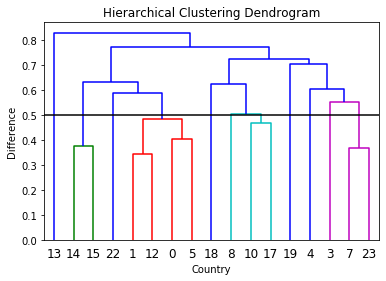

In [26]:
countries = list(map(lambda x: country_list[countries_with_enough_data[x]], list(range(17))))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    print(model.n_clusters_)
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.axhline(y=0.5, c='k')
    return linkage_matrix


#Perform hierarchical clustering on the distance matrix with AgglomerativeClustering
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10, affinity="precomputed", linkage = \
                                       "complete")
cluster_model.fit(jensenshannon_matrix)
#The output prints an array which shows which group/cluster each index falls in i.e. 1st, 2nd... belong to cluster 1
plt.title("Hierarchical Clustering Dendrogram")
linkage_matrix = plot_dendrogram(cluster_model, labels=countries_with_enough_data, truncate_mode='level', p=10, show_contracted=True)
plt.xlabel("Country")
plt.ylabel("Difference")
plt.show()


The dendrogram above shows the clusters produced with all of the countries from countries_with_enough_data on the x-axis and the difference/height on the y-axis. To select the number of clusters for our hierarchical forecasting model, we want to look for large jumps in difference between intersecting clusters. For simplicity, going to start by dividing into two clusters - blue and green. Tree will look like:

                                                    total
                                                /          \
                                            cluster_1       cluster 2
                                            /                  \       
                                        13 14 10 18 4 19        22 8 15 7 23 3 17 0 12 1 5

In [27]:
#Visualizing our clusters
clusters = fcluster(linkage_matrix, 10, criterion='distance')
clusters
# Figure out why this is not working
c, coph_dists = cophenet(linkage_matrix, pdist(jensenshannon_matrix))
print(c)

0.6839022752395594


The value outputted by the cophenet function is pretty close to 1 which means it perserves our original distances well.

### Building a Simple Hierarchical Forecasting Model

Documentation: https://scikit-hts.readthedocs.io/en/latest/readme.html
Examples: https://github.com/carlomazzaferro/scikit-hts-examples



In [28]:
"""
Code to automate generating tree dictionary - but can ignore till simple model is built
id2name = dict(zip(range(len(countries_with_enough_data)), countries_with_enough_data))

#Step 1 - Convert data from dendrogram into a tree like structure for forecasting model
T = to_tree(linkage_matrix, rd=False)

# Create a nested dictionary from the ClusterNode's returned by SciPy
def add_node(node, parent ):
    # First create the new node and append it to its parent's children
    newNode = dict( node_id=node.id, children=[] )
    parent["children"].append( newNode )

    # Recursively add the current node's children
    if node.left: add_node( node.left, newNode )
    if node.right: add_node( node.right, newNode )

dict_tree = dict(children=[], name="root")
add_node(T, dict_tree)
print(dict_tree)
#dictionary created won't have names so need to label tree 

# Label each node with the names of each leaf in its subtree
def label_tree( n ):
    # If the node is a leaf, then we have its name
    if len(n["children"]) == 0:
        leafNames = [ id2name[n["node_id"]] ]
        print(leafNames)

    # If not, flatten all the leaves in the node's subtree
    else:
        leafNames = reduce(lambda ls, c: ls + label_tree(c), n["children"], [])

    # Delete the node id since we don't need it anymore and
    # it makes for cleaner JSON
    del n["node_id"]

    # Labeling convention: "-"-separated leaf names
    n["name"] = name = "-".join(sorted(map(str, leafNames)))
    
label_tree( dict_tree["children"][0] )
"""

'\nCode to automate generating tree dictionary - but can ignore till simple model is built\nid2name = dict(zip(range(len(countries_with_enough_data)), countries_with_enough_data))\n\n#Step 1 - Convert data from dendrogram into a tree like structure for forecasting model\nT = to_tree(linkage_matrix, rd=False)\n\n# Create a nested dictionary from the ClusterNode\'s returned by SciPy\ndef add_node(node, parent ):\n    # First create the new node and append it to its parent\'s children\n    newNode = dict( node_id=node.id, children=[] )\n    parent["children"].append( newNode )\n\n    # Recursively add the current node\'s children\n    if node.left: add_node( node.left, newNode )\n    if node.right: add_node( node.right, newNode )\n\ndict_tree = dict(children=[], name="root")\nadd_node(T, dict_tree)\nprint(dict_tree)\n#dictionary created won\'t have names so need to label tree \n\n# Label each node with the names of each leaf in its subtree\ndef label_tree( n ):\n    # If the node is a lea

In [40]:
#TODO: figure out how to automatically generate this disctionary for different max_distances used for the dendrogram
#NOTE: the structure of the tree will affect the output of the prediction (even if the lowest level nodes are the
# same for different trees
nodes = {"total": ["cluster_1", "cluster_2"],
        "cluster_1": ["13", "14", "15", "22", "1", "12", "0", "5"],
        "cluster_2": ["18", "8", "10", "17", "19", "4", "3", "7", "23"]}

nodes_test = {"total": [str(x) for x in countries_with_enough_data]}

#hts requires each of the nodes in the tree to be added as a column in pandas dataframe. Thus, we require a df with
# columns: date total cluster_1 cluster_2 13 14 10 18 4 19 22 8 15 7 23 3 17 0 12 1 5

tree = HierarchyTree.from_nodes(nodes, hts_dataframe, root="total")
print(tree)
print(hts_dataframe.head())

- total
   |- cluster_1
   |  |- 13
   |  |- 14
   |  |- 10
   |  |- 18
   |  |- 4
   |  - 19
   - cluster_2
      |- 22
      |- 8
      |- 15
      |- 7
      |- 23
      |- 3
      |- 17
      |- 0
      |- 12
      |- 1
      - 5

               total  cluster_1  cluster_2   13        14   10   18    4   19  \
Date                                                                            
2005-01-31  0.044402   0.003614   0.040787  0.0  0.003614  0.0  0.0  0.0  0.0   
2005-02-28  0.051949   0.001281   0.050668  0.0  0.001281  0.0  0.0  0.0  0.0   
2005-03-31  0.020676   0.002817   0.017858  0.0  0.002817  0.0  0.0  0.0  0.0   
2005-04-30  0.028339   0.006318   0.022021  0.0  0.006318  0.0  0.0  0.0  0.0   
2005-05-31  0.000000   0.000000   0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   

                  22    8        15         7        23    3   17         0  \
Date                                                                          
2005-01-31  0.001379  0.0  0.000000  0.

In [44]:
#create a simple prophet model and fit it to the data
clf = HTSRegressor(model="prophet", revision_method='OLS', n_jobs=0)
model = clf.fit(hts_dataframe_train, nodes)

Fitting models:   0%|          | 0/20 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  10%|█         | 2/20 [00:00<00:01, 11.11it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  15%|█▌        | 3/20 [00:00<00:01, 10.35it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

In [46]:
#predict 12 steps ahead on test data
predicted_prophet = model.predict(steps_ahead=12)


Fitting models: 100%|██████████| 20/20 [00:42<00:00,  2.10s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x1a2fb5b8d0>


0.014705882352941176


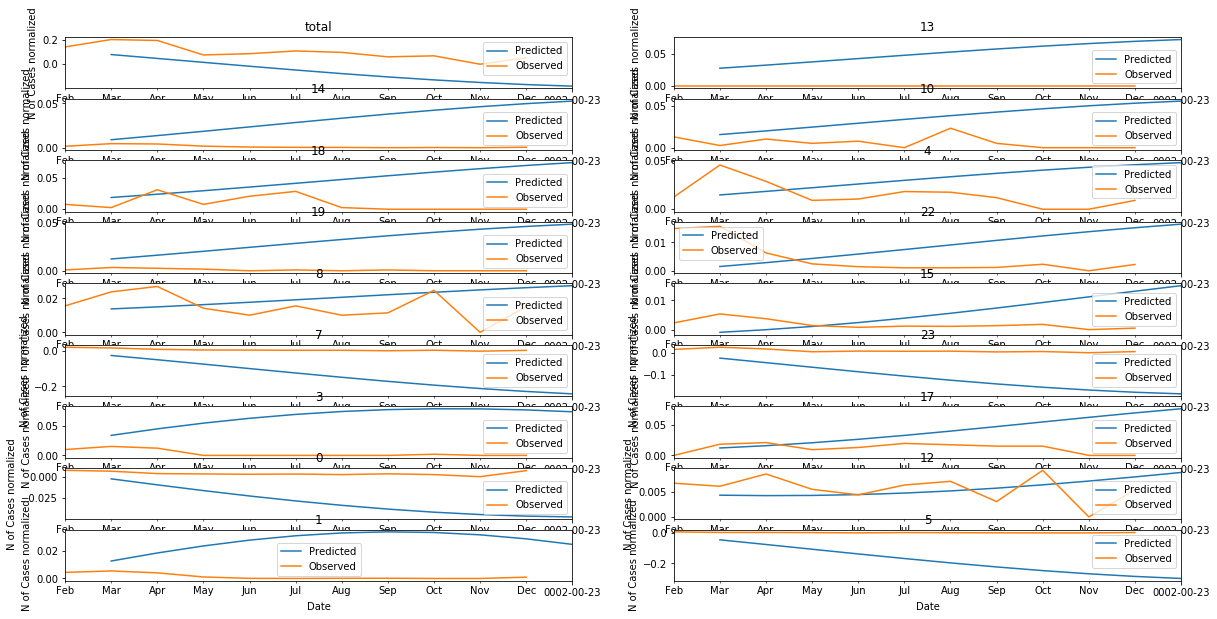

In [49]:
predictions = predicted_prophet[-11:]

def check_accuracy(predictions):
    percentage_difference = abs((hts_dataframe_test - predictions)/hts_dataframe_test)
    print((percentage_difference<0.2).sum().sum()/(12*17))

def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        predictions[col].plot(ax=ax, label="Predicted")
        hts_dataframe_test[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Cases normalized")
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%M-%d'))

fig, axes = plt.subplots(9, 2, figsize=(20, 10))
plot_results(list(hts_dataframe), axes, predicted_autoarima)
    
check_accuracy(predictions)

Fitting models:   0%|          | 0/18 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   6%|▌         | 1/18 [00:00<00:02,  8.43it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  11%|█         | 2/18 [00:00<00:02,  7.33it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

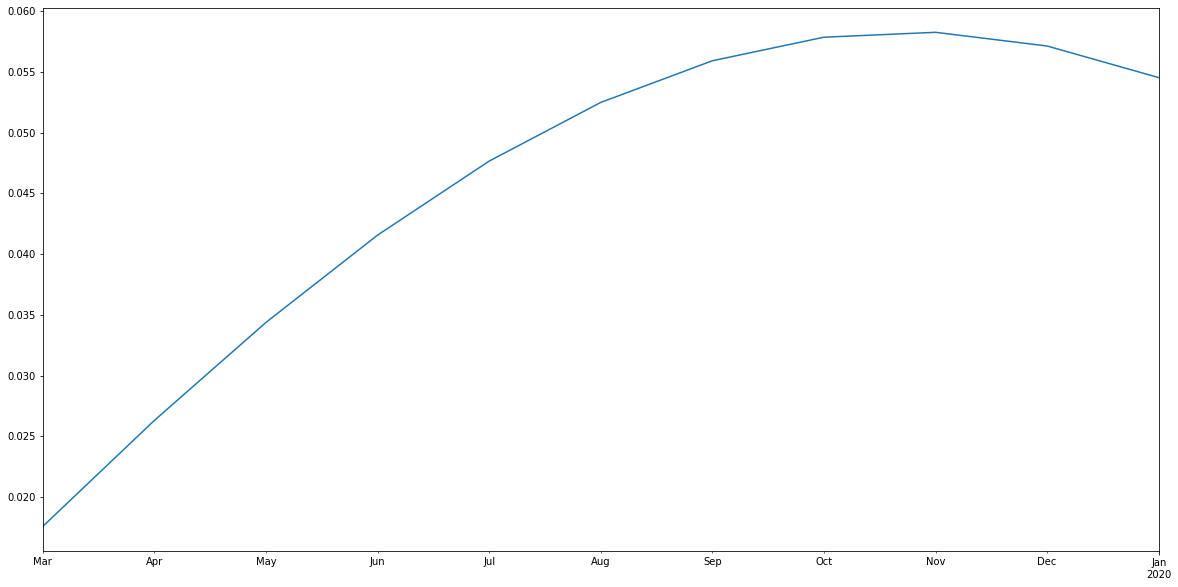

In [34]:
#Understanding what's going on
nodes_one = {"total": [str(x) for x in countries_with_enough_data]}
hts_new = hts_dataframe.drop(columns=["cluster_1", "cluster_2"])
clf_test = HTSRegressor(model="prophet", revision_method='OLS', n_jobs=0)
hts_new_test = hts_new[-11:]
hts_new = hts_new[:-11]
model_one = clf_test.fit(hts_new, nodes_one)
preds = model_one.predict(steps_ahead=12)
preds = preds[-11:]
fig, ax = plt.subplots(1,1, figsize=(20,10))
preds["1"].plot(ax=ax, label="predicted")


In [35]:
print(preds["1"])

2019-03-31    0.017580
2019-04-30    0.026303
2019-05-31    0.034373
2019-06-30    0.041557
2019-07-31    0.047651
2019-08-31    0.052481
2019-09-30    0.055912
2019-10-31    0.057851
2019-11-30    0.058255
2019-12-31    0.057128
2020-01-31    0.054528
Name: 1, dtype: float64
